In [131]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 
from scipy.stats import sem, linregress

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_drug_data = pd.read_csv(mouse_drug_data_to_load)
clinical_trial_data = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset
drug_trial_data = pd.merge(mouse_drug_data, clinical_trial_data, how='outer', on='Mouse ID')

# Display the data table for preview
drug_trial_data.head(10)

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2
5,f234,Stelasyn,25,52.178602,2
6,f234,Stelasyn,30,56.873817,2
7,f234,Stelasyn,35,57.748758,2
8,x402,Stelasyn,0,45.000000,0
9,x402,Stelasyn,5,46.327570,1


## Tumor Response to Treatment

In [132]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
# Convert to DataFrame
avg_drug_time_tuVol = pd.DataFrame(drug_trial_data.groupby(['Drug', 'Timepoint']).mean()['Tumor Volume (mm3)']).reset_index(level=['Drug', 'Timepoint'])
avg_drug_time_tuVol =  avg_drug_time_tuVol.rename(columns={'Tumor Volume (mm3)': 'Average Tumor Volume (mm3)'})
# Preview DataFrame
avg_drug_time_tuVol.head(10)

,Drug,Timepoint,Average Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325
5,Capomulin,25,39.939528
6,Capomulin,30,38.769339
7,Capomulin,35,37.816839
8,Capomulin,40,36.958001
9,Capomulin,45,36.236114


In [133]:
#drug_trial_data = drug_trial_data.sort_values(['Mouse ID','Drug', 'Timepoint'])
#drug_trial_data

In [134]:
# Get list of drug names and available timepoints
drugs = drug_trial_data['Drug'].drop_duplicates().tolist()
timepoints = drug_trial_data['Timepoint'].drop_duplicates().tolist()

In [135]:
# Calculate std. err for Average tumor volume each timepoint and each drug
# store result into a list of std. errs of all timepoints for each drug: [d1_err(t=0),...,d1_err(t=45),..., d10_err(t=0),...,d10_err(t=45)]
tuVol_stdErr = []
Drug_col = []
Timepoint_col = []

for drug in drugs:
    for t in timepoints:
        tuVol_stdErr.append(sem(drug_trial_data[(drug_trial_data['Drug']== drug) & (drug_trial_data['Timepoint']== t )]['Tumor Volume (mm3)']))
        Drug_col.append(drug)
        Timepoint_col.append(t)
        

In [136]:
stdErr_drug_time_tuVol = pd.DataFrame({'Drug': Drug_col,
                                       'Timepoint': Timepoint_col,
                                       'Tumor Volume Std. Error': tuVol_stdErr })

stdErr_drug_time_tuVol.sort_values(['Drug','Timepoint']).reset_index(drop=True).head(10)

,Drug,Timepoint,Tumor Volume Std. Error
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731
5,Capomulin,25,0.881642
6,Capomulin,30,0.934460
7,Capomulin,35,1.052241
8,Capomulin,40,1.223608
9,Capomulin,45,1.223977


In [137]:
# Minor Data Munging to Re-Format the Data Frames

In [138]:
avg_drug_time_tuVol = avg_drug_time_tuVol.sort_values(['Drug','Timepoint'])
stdErr_drug_time_tuVol = stdErr_drug_time_tuVol.sort_values(['Drug','Timepoint'])

df_V_list = []
df_Err_list =[]
# Goal: create DataFrame for each drug then combine into big DataFrame with drug names as columns ID and timepoint as index
# Result: Table of Avg. tumor volume and std. err with drug name as columns ID and timepoint as index
# create dictionary for each druge: {drugname: [,t0, t1, t2, t3 ... t45]} then
# convert to DataFrame with index = timepoints
# collect into a list of DataFrame: [df_drug1, df_drug2, ...]
for drug in drugs:
        dic_V = {drug: avg_drug_time_tuVol[avg_drug_time_tuVol['Drug']==drug]['Average Tumor Volume (mm3)'].tolist()}
        df_V_list.append(pd.DataFrame(dic_V, index=timepoints))

        dic_Err = {drug: stdErr_drug_time_tuVol[stdErr_drug_time_tuVol['Drug']==drug]['Tumor Volume Std. Error'].tolist()}
        df_Err_list.append(pd.DataFrame(dic_Err, index=timepoints))

# for loop to merge all items in the list
# initialize: merge df_V_list[0] and df_V_list[1]
new_V_df = pd.merge(df_V_list[0], df_V_list[1], left_index=True, right_index=True)
new_Err_df = pd.merge(df_Err_list[0], df_Err_list[1], left_index=True, right_index=True )

for i in range(2, len(df_V_list)):
    new_V_df = pd.merge(new_V_df, df_V_list[i], left_index=True, right_index=True)
    new_Err_df = pd.merge(new_Err_df, df_Err_list[i], left_index=True, right_index=True) 

# Preview that Reformatting worked 
new_V_df.index.name = "Timepoint"
new_V_df.columns.name = "Drug"

new_Err_df.index.name = "Timepoint"
new_Err_df.columns.name = "Drug"

In [139]:
new_V_df

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,47.527452,47.248967,46.796098,47.389175,44.266086,47.062001,46.503051,46.851818,43.944859,47.125589
10,49.463844,49.101541,48.694210,49.582269,43.084291,49.403909,48.285125,48.689881,42.531957,49.423329
15,51.529409,51.067318,50.933018,52.399974,42.064317,51.296397,50.094055,50.779059,41.495061,51.359742
20,54.067395,53.346737,53.644087,54.920935,40.716325,53.197691,52.157049,53.170334,40.238325,54.364417
25,56.166123,55.504138,56.731968,57.678982,39.939528,55.715252,54.287674,55.432935,38.974300,57.482574
30,59.826738,58.196374,59.559509,60.994507,38.769339,58.299397,56.769517,57.713531,38.703137,59.809063
35,62.440699,60.350199,62.685087,63.371686,37.816839,60.742461,58.827548,60.089372,37.451996,62.420615
40,65.356386,63.045537,65.600754,66.068580,36.958001,63.162824,61.467895,62.916692,36.574081,65.052675


In [140]:
new_Err_df

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.239862,0.231708,0.202385,0.264819,0.448593,0.235102,0.164505,0.188950,0.482955,0.218091
10,0.433678,0.376195,0.319415,0.357421,0.702684,0.282346,0.236144,0.263949,0.720225,0.402064
15,0.493261,0.466109,0.444378,0.580268,0.838617,0.357705,0.332053,0.370544,0.770432,0.614461
20,0.621889,0.555181,0.595260,0.726484,0.909731,0.476210,0.359482,0.533182,0.786199,0.839609
25,0.741922,0.577401,0.813706,0.755413,0.881642,0.550315,0.439356,0.602513,0.746991,1.034872
30,0.899548,0.746045,0.975496,0.934121,0.934460,0.631061,0.490620,0.800043,0.864906,1.218231
35,1.003186,1.084929,1.013769,1.127867,1.052241,0.984155,0.692248,0.881426,0.967433,1.287481
40,1.410435,1.564779,1.118567,1.158449,1.223608,1.055220,0.708505,0.998515,1.128445,1.370634


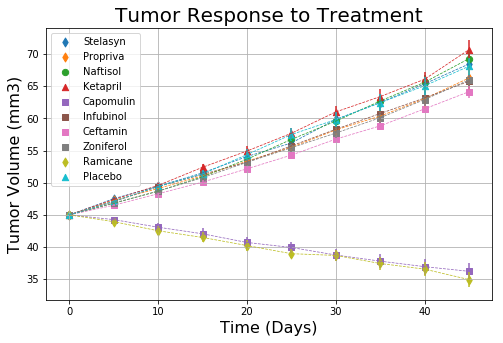

In [141]:
markers = ['o', '^', 's', 'd']

plt.figure(figsize=(8, 5))
plt.title("Tumor Response to Treatment", fontsize=20)

# plot points
for drug in drugs:
        plt.scatter(new_V_df.index.tolist(), 
                    new_V_df[drug], 
                    marker=random.choice(markers), 
                    edgecolors=None, 
                    s=40, 
                    alpha=1)
        
plt.legend(loc="best", fontsize=10)

# plot error bars
for drug in drugs:        
        plt.errorbar(new_Err_df.index.tolist(),
                     new_V_df[drug],
                     new_Err_df[drug],
                     fmt='',
                     linestyle='')

# plot dashed lines between points       
for drug in drugs:
        plt.plot(new_V_df.index.tolist(), 
                 new_V_df[drug],
                 linestyle='--',
                 linewidth=0.75)
    
plt.xlabel("Time (Days)", fontsize=16)
plt.ylabel("Tumor Volume (mm3)", fontsize=16)
plt.grid()
plt.show()

## Metastatic Response to Treatment

In [142]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

# Convert to DataFrame

# Preview DataFrame
avg_drug_time_MetSites = pd.DataFrame(drug_trial_data.groupby(['Drug', 'Timepoint']).mean()['Metastatic Sites']).reset_index(level=['Drug', 'Timepoint'])
avg_drug_time_MetSites = avg_drug_time_MetSites.rename(columns={'Metastatic Sites': 'Average Metastatic Sites'})
avg_drug_time_MetSites.head()

,Drug,Timepoint,Average Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [143]:
# Calculate std. err for Average metastatic sites each timepoint and each drug
# store result into a list of std. errs of all timepoints for each drug: [d1_err(t=0),...,d1_err(t=45),..., d10_err(t=0),...,d10_err(t=45)]
MetSites_stdErr = []
Drug_col = []
Timepoint_col = []

for drug in drugs:
    for t in timepoints:
        MetSites_stdErr.append(sem(drug_trial_data[(drug_trial_data['Drug']== drug) & (drug_trial_data['Timepoint']== t )]['Metastatic Sites']))
        Drug_col.append(drug)
        Timepoint_col.append(t)


In [144]:
stdErr_drug_time_MetSites = pd.DataFrame({'Drug': Drug_col,
                                       'Timepoint': Timepoint_col,
                                       'Metastatic Sites Std. Error': tuVol_stdErr })

stdErr_drug_time_MetSites.sort_values(['Drug','Timepoint']).reset_index(drop=True).head()

,Drug,Timepoint,Metastatic Sites Std. Error
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [145]:
avg_drug_time_MetSites = avg_drug_time_MetSites.sort_values(['Drug','Timepoint'])
stdErr_drug_time_MetSites = stdErr_drug_time_MetSites.sort_values(['Drug','Timepoint'])

df_M_list = []
df_mErr_list =[]
# Goal: create DataFrame for each drug then combine into big DataFrame with drug names as columns ID and timepoint as index
# Result: Table of Avg. tumor volume and std. err with drug name as columns ID and timepoint as index
# create dictionary for each druge: {drugname: [,t0, t1, t2, t3 ... t45]} then
# convert to DataFrame with index = timepoints
# collect into a list of DataFrame: [df_drug1, df_drug2, ...]
for drug in drugs:
        dic_M = {drug: avg_drug_time_MetSites[avg_drug_time_MetSites['Drug']==drug]['Average Metastatic Sites'].tolist()}
        df_M_list.append(pd.DataFrame(dic_M, index=timepoints))

        dic_mErr = {drug: stdErr_drug_time_MetSites[stdErr_drug_time_MetSites['Drug']==drug]['Metastatic Sites Std. Error'].tolist()}
        df_mErr_list.append(pd.DataFrame(dic_mErr, index=timepoints))

# for loop to merge all items in the list
# initialize: merge df_V_list[0] and df_V_list[1]
new_M_df = pd.merge(df_M_list[0], df_M_list[1], left_index=True, right_index=True)
new_mErr_df = pd.merge(df_mErr_list[0], df_mErr_list[1], left_index=True, right_index=True )

for i in range(2, len(df_V_list)):
    new_M_df = pd.merge(new_M_df, df_M_list[i], left_index=True, right_index=True)
    new_mErr_df = pd.merge(new_mErr_df, df_mErr_list[i], left_index=True, right_index=True) 

# Preview that Reformatting worked 
new_M_df.index.name = "Timepoint"
new_M_df.columns.name = "Drug"

new_mErr_df.index.name = "Timepoint"
new_mErr_df.columns.name = "Drug"

In [146]:
new_M_df.head()

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.240000,0.320000,0.260870,0.304348,0.160000,0.280000,0.380952,0.166667,0.120000,0.375000
10,0.478261,0.565217,0.523810,0.590909,0.320000,0.666667,0.600000,0.500000,0.250000,0.833333
15,0.782609,0.764706,0.857143,0.842105,0.375000,0.904762,0.789474,0.809524,0.333333,1.250000
20,0.952381,1.000000,1.150000,1.210526,0.652174,1.050000,1.111111,1.294118,0.347826,1.526316


In [147]:
new_mErr_df.head()

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.239862,0.231708,0.202385,0.264819,0.448593,0.235102,0.164505,0.188950,0.482955,0.218091
10,0.433678,0.376195,0.319415,0.357421,0.702684,0.282346,0.236144,0.263949,0.720225,0.402064
15,0.493261,0.466109,0.444378,0.580268,0.838617,0.357705,0.332053,0.370544,0.770432,0.614461
20,0.621889,0.555181,0.595260,0.726484,0.909731,0.476210,0.359482,0.533182,0.786199,0.839609


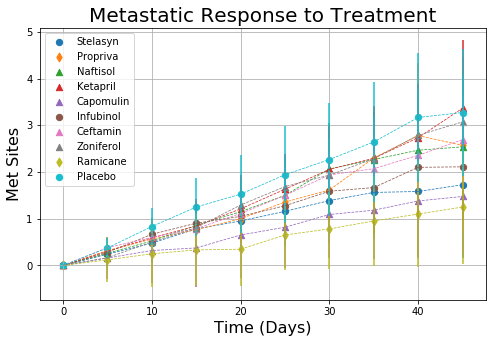

In [148]:
markers = ['o', '^', 's', 'd']

plt.figure(figsize=(8, 5))
plt.title("Metastatic Response to Treatment", fontsize=20)

# plot points
for drug in drugs:
        plt.scatter(new_M_df.index.tolist(), 
                    new_M_df[drug], 
                    marker=random.choice(markers), 
                    edgecolors=None, 
                    s=40, 
                    alpha=1)
        
plt.legend(loc="best", fontsize=10)

# plot error bars
for drug in drugs:        
        plt.errorbar(new_mErr_df.index.tolist(),
                     new_M_df[drug],
                     new_mErr_df[drug],
                     fmt='',
                     linestyle='')

# plot dashed lines between points       
for drug in drugs:
        plt.plot(new_M_df.index.tolist(), 
                 new_M_df[drug],
                 linestyle='--',
                 linewidth=0.75)
    
plt.xlabel("Time (Days)", fontsize=16)
plt.ylabel("Met Sites", fontsize=16)
plt.grid()
plt.show()
plt.show()

## Survival Rates

In [149]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
# Convert to DataFrame
drug_time_mouseCount = drug_trial_data.groupby(['Drug','Timepoint']).count()['Mouse ID'].reset_index(level=['Drug', 'Timepoint'])
drug_time_mouseCount = drug_time_mouseCount.rename(columns={'Mouse ID': 'Mouse Count'})
# Preview DataFrame
drug_time_mouseCount.head()

,Drug,Timepoint,Mouse Count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [150]:
drug_time_mouseCount = drug_time_mouseCount.sort_values(['Drug', 'Timepoint'])

df_MC_list = []

for drug in drugs:
    dic_MC = {drug: drug_time_mouseCount[drug_time_mouseCount['Drug']==drug]['Mouse Count'].tolist()}
    df_MC_list.append(pd.DataFrame(dic_MC, index=timepoints))

new_MC_df = pd.merge(df_MC_list[0], df_MC_list[1], left_index=True, right_index=True)

for i in range(2, len(df_MC_list)):
    new_MC_df = pd.merge(new_MC_df, df_MC_list[i], left_index=True, right_index=True )
    
new_MC_df.index.name = "Timepoint"
new_MC_df.columns.name = "Drug"

new_MC_df

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,26,26,25,25,25,25,25,25,25,25
5,25,25,23,23,25,25,21,24,25,24
10,23,23,21,22,25,21,20,22,24,24
15,23,17,21,19,24,21,19,21,24,20
20,21,17,20,19,23,20,18,17,23,19
25,19,14,18,19,22,18,18,16,23,17
30,18,13,15,18,22,17,16,15,23,15
35,16,10,15,17,22,12,14,14,21,14
40,12,9,15,15,21,10,14,14,20,12


In [151]:
# convert survival counts to %
for drug in drugs:
    new_MC_df[drug] = 100*(new_MC_df[drug]/new_MC_df[drug][0])

In [152]:
new_MC_df

Drug,Stelasyn,Propriva,Naftisol,Ketapril,Capomulin,Infubinol,Ceftamin,Zoniferol,Ramicane,Placebo
Timepoint,,,,,,,,,,
0,100.000000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
5,96.153846,96.153846,92.0,92.0,100.0,100.0,84.0,96.0,100.0,96.0
10,88.461538,88.461538,84.0,88.0,100.0,84.0,80.0,88.0,96.0,96.0
15,88.461538,65.384615,84.0,76.0,96.0,84.0,76.0,84.0,96.0,80.0
20,80.769231,65.384615,80.0,76.0,92.0,80.0,72.0,68.0,92.0,76.0
25,73.076923,53.846154,72.0,76.0,88.0,72.0,72.0,64.0,92.0,68.0
30,69.230769,50.000000,60.0,72.0,88.0,68.0,64.0,60.0,92.0,60.0
35,61.538462,38.461538,60.0,68.0,88.0,48.0,56.0,56.0,84.0,56.0
40,46.153846,34.615385,60.0,60.0,84.0,40.0,56.0,56.0,80.0,48.0


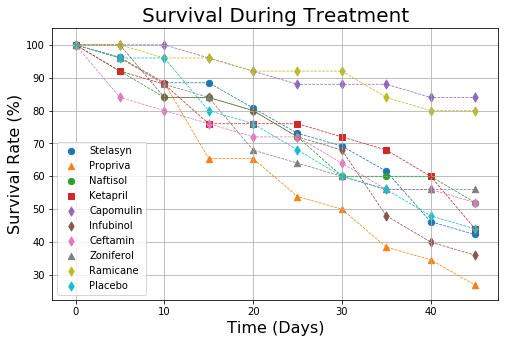

In [153]:
markers = ['o', '^', 's', 'd']

plt.figure(figsize=(8, 5))
plt.title("Survival During Treatment", fontsize=20)

for drug in drugs:
    plt.scatter(new_MC_df.index.tolist(),
                new_MC_df[drug],
                marker=random.choice(markers),
                edgecolor=None,
                s=40,
                alpha=1)

plt.legend(loc='best', fontsize = 10)

for drug in drugs:
        plt.plot(new_MC_df.index.tolist(), 
                 new_MC_df[drug],
                 linestyle='--',
                 linewidth=0.75)

plt.xlabel("Time (Days)", fontsize=16)
plt.ylabel("Survival Rate (%)", fontsize=16)
plt.grid()
plt.show()


## Summary Bar Graph

In [154]:
# Calculate the percent changes for each drug
pChangeV_list = []

for drug in drugs:
    pChangeV_list.append(
         100*((new_V_df[drug][5*(len(new_V_df.index)-1)] - new_V_df[drug][0])/ new_V_df[drug][0])
    )

    # Display the data to confirm
#for i in range(0, len(pChangeV_list)):
    
#pChangeV_list
#drugs
percChange_V = pd.DataFrame({'Drug': drugs,
              'Change': pChangeV_list}).sort_values('Change').reset_index(drop=True)
percChange_V

,Drug,Change
0,Ramicane,-22.320900
1,Capomulin,-19.475303
2,Ceftamin,42.516492
3,Infubinol,46.123472
4,Zoniferol,46.579751
5,Propriva,47.241175
6,Placebo,51.297960
7,Stelasyn,52.085134
8,Naftisol,53.923347
9,Ketapril,57.028795


In [155]:
effective = percChange_V[percChange_V['Change']<0]
ineffective = percChange_V[percChange_V['Change']>=0]

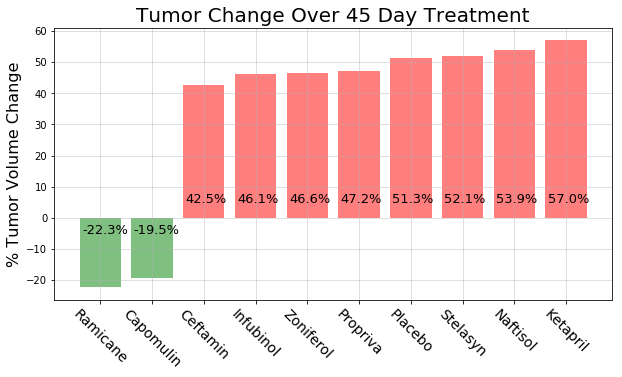

In [156]:
plt.figure(figsize=(10, 5))

plt.title("Tumor Change Over 45 Day Treatment", fontsize=20)

plt.bar(effective['Drug'], effective['Change'], color='green', alpha=0.5, align='center', linewidth=20)
plt.bar(ineffective['Drug'], ineffective['Change'], color='red', alpha=0.5, align='center')

plt.xticks(percChange_V['Drug'], rotation=-45, fontsize=14)
plt.ylabel("% Tumor Volume Change", fontsize=16)

for i in range(0, len(percChange_V)):
    plt.text(i-0.355,
             percChange_V['Change'][i]/abs(percChange_V['Change'][i])*5,
             str(round(percChange_V['Change'][i],1))+"%", 
             fontsize=13, 
             color='black')

plt.grid(alpha=0.5)

